# Clasificación por árboles de decisión


Primero importamos los módulos que usaremos


In [2]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix

Ahora leemos los datos a utilizar, preparamos el grid de parámetros para validación cruzada, y la ejecutamos


In [3]:
df = pd.read_csv("../data/match_data_full.csv")

X = df.drop(columns=["blueTeamWin"])
y = df["blueTeamWin"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10],
    "min_samples_leaf": [5, 10, 20]
}

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

Mejores parámetros: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5}
Mejor puntuación de validación cruzada: 0.7549290788882043


Ahora ejecutamos el modelo en los datos de test para validarlo.


In [4]:
y_pred = best_dt.predict(X_test)

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred, target_names=["Red Team Win", "Blue Team Win"]))

Matriz de confusión:
[[1914  561]
 [ 658 1711]]

Informe de clasificación:
               precision    recall  f1-score   support

 Red Team Win       0.74      0.77      0.76      2475
Blue Team Win       0.75      0.72      0.74      2369

     accuracy                           0.75      4844
    macro avg       0.75      0.75      0.75      4844
 weighted avg       0.75      0.75      0.75      4844



Podemos ver que su accuracy es la misma tanto en train como en test, lo que quiere decir que el modelo ha sido bien entrenado.

Ahora veremos cuáles han sido las variables más importantes a la hora de generar ramas en los árboles.


In [5]:
importancia = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_dt.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 5 Variables más importantes:")
importancia.head(5)


Top 5 Variables más importantes:


,Feature,Importance
36,totalGoldDiff,0.909291
30,dragonKillsDiff,0.049641
37,xpDiff,0.030358
3,blueTeamDragonKills,0.003152
29,totalKillsDiff,0.002817


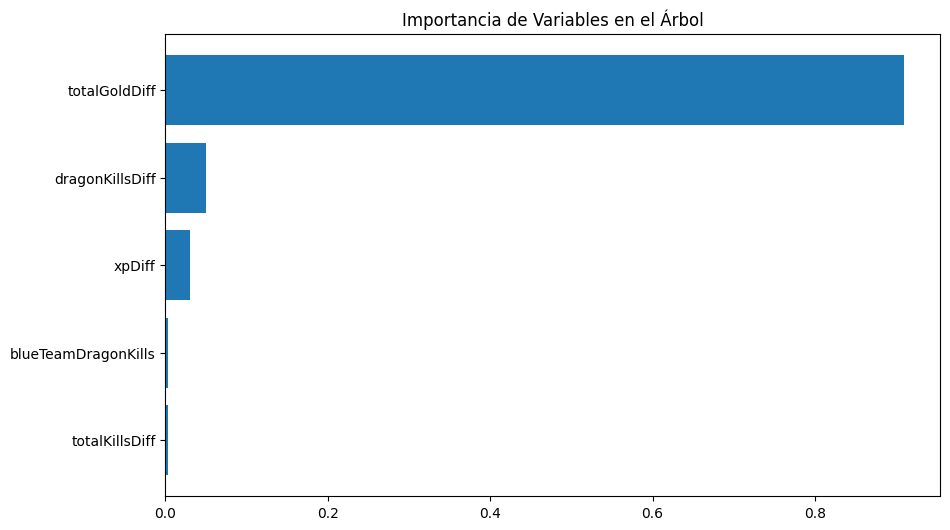

In [6]:
plt.figure(figsize=(10, 6))
plt.barh(importancia['Feature'][:5], importancia['Importance'][:5])
plt.gca().invert_yaxis()
plt.title("Importancia de Variables en el Árbol")
plt.show()

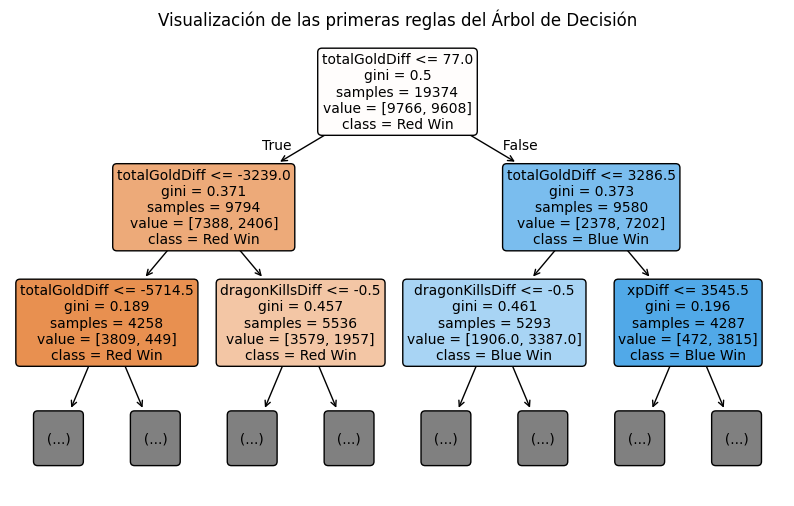

In [7]:
plt.figure(figsize=(10, 6))
plot_tree(best_dt,
          feature_names=X.columns,
          class_names=['Red Win', 'Blue Win'],
          filled=True,
          rounded=True,
          max_depth=2,
          fontsize=10)
plt.title("Visualización de las primeras reglas del Árbol de Decisión")
plt.show()

Podemos ver, como esperábamos gracias a la naturaleza de este juego, que la variable más importante es la diferencia de oro total. Luego de eso, lo que más importa son la cantidad de dragones asesinados y la cantidad de experiencia obtenida. Las demás variables prácticamente no importan.


In [ ]:
import shap

# Seleccionamos una muestra del conjunto de test para acelerar el cálculo de SHAP
sample_data = shap.sample(X_test, 50, random_state=0)

# Obtenemos el explainer SHAP
explainer = shap.TreeExplainer(best_dt, sample_data)

# Calculamos los valores SHAP para el conjunto de test
instance = X_test.iloc[[0]]
shap_values = explainer.shap_values(instance)

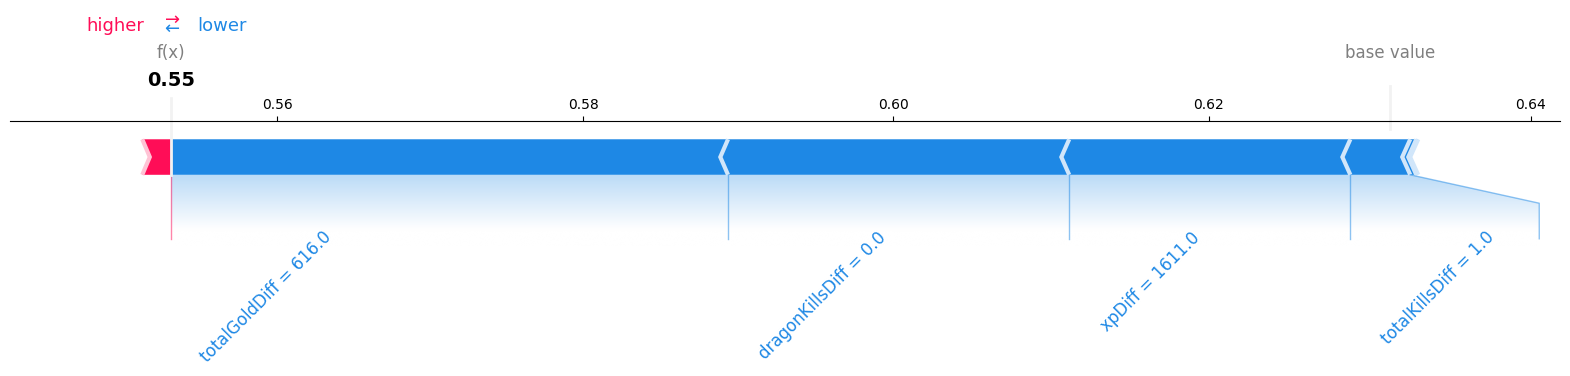

In [9]:
# Visualizamos los valores SHAP
shap.initjs()
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0][:, 0],
    instance.iloc[0],
    matplotlib=True,
    text_rotation=45,
    link="logit"
)

In [10]:
shap_values_summary = explainer.shap_values(sample_data)

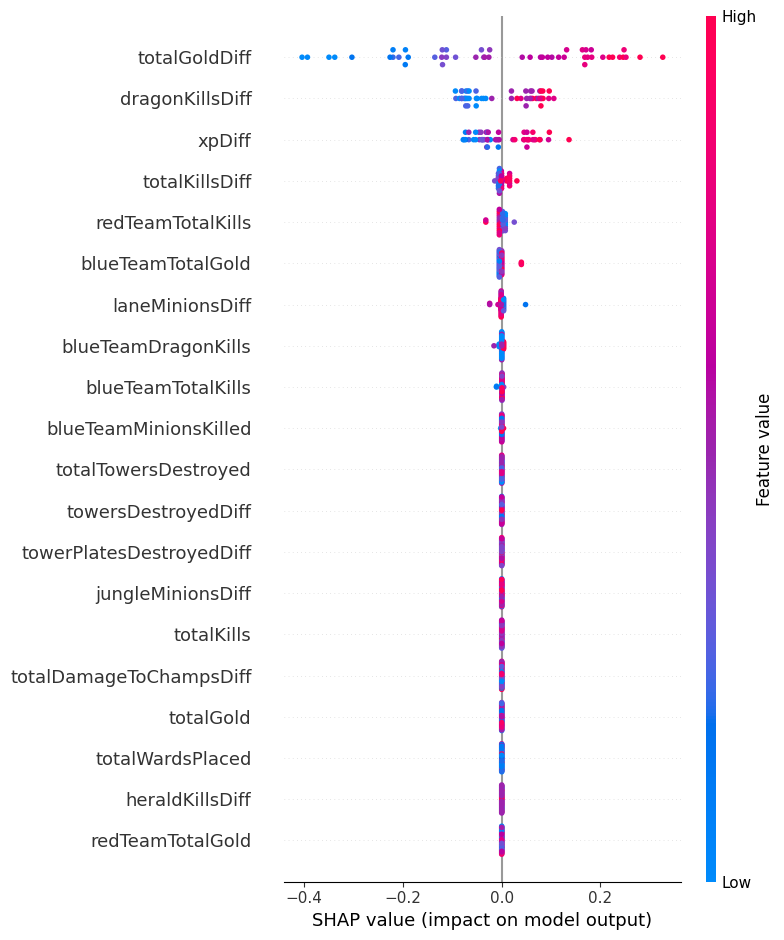

In [ ]:
plt.figure(dpi=100)
shap.summary_plot(
    shap_values_summary[:, :, 1],
    sample_data,
    plot_type="dot",
    show=False
)